In [ ]:
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorboardX

Looking in links: https://download.pytorch.org/whl/torch_stable.html

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 341, in resolve


In [ ]:
from datetime import datetime
import functools
import os
import time
from functools import partial

import gym
import numpy as np
import torch
import tqdm

from IPython.display import HTML, clear_output
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
try:
  import brax
except ImportError:
  from IPython.display import clear_output
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax


from brax import envs
from brax.training import sac
from brax.io import html
import numpy as np
if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()
from brax.envs.to_torch import JaxToTorchWrapper
from brax.envs import _envs, create_gym_env

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

CUDA_AVAILABLE = torch.cuda.is_available()
if CUDA_AVAILABLE:
    # BUG: (@lebrice): Getting a weird "CUDA error: out of memory" RuntimeError
    # during JIT, which can be "fixed" by first creating a dummy cuda tensor!
    v = torch.ones(1, device="cuda")
#Registering Brax environments in Gym
for env_name, env_class in _envs.items():
    env_id = f"brax_{env_name}-v0"
    entry_point = partial(create_gym_env, env_name=env_name)
    if env_id not in gym.envs.registry.env_specs:
        print(f"Registring brax's '{env_name}' env under id '{env_id}'.")
        gym.register(env_id, entry_point=entry_point)

Registring brax's 'ant' env under id 'brax_ant-v0'.
Registring brax's 'fast' env under id 'brax_fast-v0'.
Registring brax's 'fetch' env under id 'brax_fetch-v0'.
Registring brax's 'grasp' env under id 'brax_grasp-v0'.
Registring brax's 'halfcheetah' env under id 'brax_halfcheetah-v0'.
Registring brax's 'hopper' env under id 'brax_hopper-v0'.
Registring brax's 'humanoid' env under id 'brax_humanoid-v0'.
Registring brax's 'reacher' env under id 'brax_reacher-v0'.
Registring brax's 'reacherangle' env under id 'brax_reacherangle-v0'.
Registring brax's 'ur5e' env under id 'brax_ur5e-v0'.
Registring brax's 'walker2d' env under id 'brax_walker2d-v0'.


In [ ]:
import torch
from torchvision import transforms
class TorchBraxENV:
    def __init__(self, env_name = "ant", count = 1, batch_size = 1):
        self.name = {'ant' : 'brax_ant-v0', 'fetch' : 'brax_fetch-v0', 'grasp' : 'brax_grasp-v0', 'humanoid' : 'brax_humanoid-v0', 'reacher' : 'brax_reacher-v0'}#, 'ur5e' : 'brax_ur5e-v0'
        self.env_name = env_name
        self.agent_counter = 0
        self.agents = []
        self.obs = []
        self.action = []
        self.observation = []
        for n in range(count):
            self.agents.append(self.add_agent(env_name, self.agent_counter, batch_size))
            self.obs.append(self.agents[-1].reset())
            self.action.append([])
            self.observation.append([])
            self.agent_counter = self.agent_counter + 1

    def add_agent(self, name, id, batch_size):
        env = gym.make(self.name[name], batch_size=batch_size)
        env = JaxToTorchWrapper(env)
        return env

    def reset(self, id):
        self.initobs = self.agents[id].reset() 

    def test(self, id):
        statep = self.init_state
        qps = []
        rewards = []
        states = []
        for i in range(1000):
            action = self.env.action_space.sample()
            obs, reward, done, info, statep = self.step(statep, action)
            rewards.append(reward)
            qps.append(statep.qp)
            states.append(obs)
        print(rewards)
        return qps, states

    def visualize(self, sys, qps):
      """Renders a 3D visualization of the environment."""
      return HTML(html.render(sys, qps))
    
    def step(self, action, id):
        obs1 = self.obs[id]
        obs, reward, done, info = self.agents[id].step(action)
        self.observation[id] = obs1
        self.action[id] = action
        self.obs[id] = obs
        action = jnp.array(action[0])
        return obs, reward, done, info

code from https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch/tree/master/Char05%20DDPG

In [ ]:
import argparse
from itertools import count

import os, sys, random
import numpy as np

import gym
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from tensorboardX import SummaryWriter

'''
Implementation of Deep Deterministic Policy Gradients (DDPG) with pytorch 
riginal paper: https://arxiv.org/abs/1509.02971
Not the author's implementation !
'''


mode = 'train'
# OpenAI gym environment name, # ['BipedalWalker-v2', 'Pendulum-v0'] or any continuous environment
# Note that DDPG is feasible about hyper-parameters.
env_name = 'Ant-v2'
tau=0.005
target_update_interval=1
test_iteration=1
learning_rate=1e-4
gamma=0.99
capacity=1000000
batch_size=100
seed=False
random_seed=9527
# optional parameters
sample_frequency=2000
render=False
log_interval=50
load=False
render_interval=100
exploration_noise=0.1
max_episode=30
print_log=5
update_iteration=200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
script_name = os.path.basename('__file__')


if seed:
    #env.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

state_dim = 87#env.observation_space.shape[0]
action_dim = 8#env.action_space.shape[0]
max_action = 1#float(env.env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device) # min value

directory = './exp' + script_name + env_name +'./'

class Replay_buffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=capacity):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind:
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1)


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400 , 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        #print(x.shape, u.shape)
        if u.shape[1] == 1:
            u = u.squeeze(1)
        x = F.relu(self.l1(torch.cat([x, u], 1)))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.replay_buffer = Replay_buffer()
        self.writer = SummaryWriter(directory)

        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self):

        for it in range(update_iteration):
            # Sample replay buffer
            x, y, u, r, d = self.replay_buffer.sample(batch_size)
            state = torch.FloatTensor(x).to(device)
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)
            done = torch.FloatTensor(1-d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            self.writer.add_scalar('Loss/critic_loss', critic_loss, global_step=self.num_critic_update_iteration)
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state)).mean()
            self.writer.add_scalar('Loss/actor_loss', actor_loss, global_step=self.num_actor_update_iteration)

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1

    def save(self):
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')
        # print("====================================")
        # print("Model has been saved...")
        # print("====================================")

    def load(self, name1, name2):
        self.actor.load_state_dict(torch.load(directory + name1))
        self.critic.load_state_dict(torch.load(directory + name2))
        print("====================================")
        print("model has been loaded...")
        print("====================================")

def individualDDPG(env, mode = "train"):
    id = 0
    agent = DDPG(state_dim, action_dim, max_action)
    ep_r = 0
    if mode == 'test':
        agent.load()
        qps = []
        for i in range(test_iteration):
            env.reset()
            state = env.initobs.squeeze(0).cpu().numpy()
            st = env.init_state
            for t in count():
                action = agent.select_action(state)
                action = torch.tensor(action).unsqueeze(0)
                next_state, reward, done, info, st = env.step(st, action)
                qps.append(st.qp)
                reward = reward.cpu().numpy()[0]
                done = bool(done.cpu().numpy()[0])
                ep_r += reward
                #env.render()
                next_state = next_state.squeeze(0).cpu().numpy()
                if done :#or t >= max_length_of_trajectory:
                    print("Ep_i \t{}, the ep_r is \t{:0.2f}, the step is \t{}".format(i, ep_r, t))
                    ep_r = 0
                    break
                state = next_state
            return qps

    elif mode == 'train':
        if load: agent.load()
        total_step = 0
        log = []
        logmean = []
        for i in range(max_episode):
            total_reward = 0
            step =0
            env.reset(id)
            state = env.obs[id].squeeze(0).cpu().numpy()
            for t in count():
                action = agent.select_action(state)
                action = (action + np.random.normal(0, exploration_noise, size=8)).clip(
                    env.agents[id].action_space.low, env.agents[id].action_space.high)

                next_state, reward, done, info = env.step(action, id)
                reward = reward.cpu().numpy()[0]
                done = bool(done.cpu().numpy()[0])
                next_state = next_state.squeeze(0).cpu().numpy()
                agent.replay_buffer.push((state, next_state, action, reward, np.float(done)))

                state = next_state
                if done:
                    break
                step += 1
                total_reward += reward
            total_step += step+1
            logmean.append(total_reward/(step+1))
            print("Total T:{} Episode: \t{} Total Reward: \t{:0.2f}".format(total_step, i, total_reward))
            log.append(total_reward)
            agent.update()
           # "Total T: %d Episode Num: %d Episode T: %d Reward: %f

            if i % log_interval == 0:
                agent.save()
        return log, logmean
    else:
        raise NameError("mode wrong!!!")

In [ ]:
env = TorchBraxENV("ant",1)

In [ ]:
l_ind, ml_ind = individualDDPG(env)

Total T:1000 Episode: 	0 Total Reward: 	937.52
Total T:2000 Episode: 	1 Total Reward: 	-2704.41
Total T:3000 Episode: 	2 Total Reward: 	-2689.66
Total T:4000 Episode: 	3 Total Reward: 	-1561.22
Total T:5000 Episode: 	4 Total Reward: 	-2664.71
Total T:6000 Episode: 	5 Total Reward: 	-1755.17
Total T:7000 Episode: 	6 Total Reward: 	-2550.89
Total T:8000 Episode: 	7 Total Reward: 	-2448.73
Total T:9000 Episode: 	8 Total Reward: 	-2360.56
Total T:10000 Episode: 	9 Total Reward: 	-2497.70
Total T:11000 Episode: 	10 Total Reward: 	-1391.19
Total T:12000 Episode: 	11 Total Reward: 	-1115.64
Total T:13000 Episode: 	12 Total Reward: 	-642.78
Total T:14000 Episode: 	13 Total Reward: 	-671.05
Total T:15000 Episode: 	14 Total Reward: 	-1240.16
Total T:16000 Episode: 	15 Total Reward: 	481.49
Total T:17000 Episode: 	16 Total Reward: 	591.91
Total T:18000 Episode: 	17 Total Reward: 	399.04
Total T:19000 Episode: 	18 Total Reward: 	756.63
Total T:20000 Episode: 	19 Total Reward: 	747.09
Total T:21000

In [ ]:
class RandomAgent:
    def __init__(self,env,id):
        self.env = env
        self.id = id
    def step(self):
        action = self.env.agents[self.id].action_space.sample()
        #action = torch.tensor(action).unsqueeze(0)
        return self.env.step(action, self.id)
class PercentAgent:
    def __init__(self,env,id,p0,pi,limit):
        self.env = env
        self.id = id
        self.p0 = p0
        self.pi = pi
        self.limit = limit
        self.agent = DDPG(state_dim, action_dim, max_action)
        self.agent.load('actorp.pth','criticp.pth')
    def step(self):
        if self.p0 < self.limit:
            self.p0 = self.p0 + self.pi
        if np.random.rand()> self.p0:
            action = self.env.agents[self.id].action_space.sample()
            #action = torch.tensor(action).unsqueeze(0)
            return self.env.step(action, self.id)
        else:
            state = self.env.obs[self.id].squeeze(0).cpu().numpy()
            action = self.agent.select_action(state)
            action = torch.tensor(action).unsqueeze(0)
            return self.env.step(action, self.id)
class OtherAgents:
    def __init__(self, env, radndom_agents = 30, percent_agents = 1, p0 = [0.5], pi = [0], limit = [1]):
        self.env = env
        self.agents = []
        for i in range(radndom_agents):
            self.agents.append(RandomAgent(env, len(self.agents)+1))
        for j in range(percent_agents):
            self.agents.append(PercentAgent(env, len(self.agents)+1, p0[j], pi[j], limit[j]))
    def step(self):
        for id in range(len(self.agents)):
            self.agents[id].step()

In [ ]:
class socialDDPG:
    def __init__(self, env, id):
        self.id = id
        self.env = env
        self.preference = np.zeros(len(self.env.agents))+0.0001
        self.mean_reward = 0
        self.other = OtherAgents(env)
        self.frequency = {}
        self.memorys = {}
        self.memorya = {}
        for i in range(len(env.agents)):
            self.frequency[i] = {}
            self.memorys[i] = []
            self.memorya[i] = []
    def update_social_preference(self, index, Ri, alpha = 0.1):
        '''Update others with same action selected:'''
        self.preference = np.round(self.preference,2)
        d = np.sum(np.exp(self.preference))
        mask = np.ones(len(self.preference))*alpha
        self.preference = self.preference - mask * (Ri - self.mean_reward) * np.exp(self.preference)/d
        self.preference[index] = self.preference[index] + alpha * (Ri - self.mean_reward)
        return
    def train(self):
        ep_r = 0
        total_step = 0
        agent = DDPG(state_dim, action_dim, max_action)
        log =[]
        logmean = []
        for i in range(max_episode):
            total_reward = 0
            step =0
            self.env.reset(self.id)
            state = self.env.obs[self.id].squeeze(0).cpu().numpy()
            for t in count():
                self.other.step()
                self.update_other()
                ind = self.select_agent_social()
                if ind == self.id:
                    action = agent.select_action(state)
                else:
                    index, dist = self.distance_2(self.env.obs[self.id][0],ind)
                    if True:#dist< 100:
                        action = self.memorya[ind][index]/self.frequency[ind][index]
                    else:
                        action = agent.select_action(state)
                action = (action + np.random.normal(0, exploration_noise, size=8)).clip(
                    self.env.agents[self.id].action_space.low, self.env.agents[self.id].action_space.high)

                next_state, reward, done, info = self.env.step(action, self.id)
                reward = reward.cpu().numpy()[0]
                self.mean_reward = self.mean_reward + (reward - self.mean_reward) / (total_step+step+1)
                done = bool(done.cpu().numpy()[0])
                next_state = next_state.squeeze(0).cpu().numpy()
                agent.replay_buffer.push((state, next_state, action, reward, np.float(done)))
                self.update_social_preference(ind,reward)
                state = next_state
                if done:
                    break
                step += 1
                total_reward += reward
            total_step += step+1
            logmean.append(total_reward/(step+1))
            print("Total T:{} Episode: \t{} Total Reward: \t{:0.2f}".format(total_step, i, total_reward))
            log.append(total_reward)
            agent.update()
           # "Total T: %d Episode Num: %d Episode T: %d Reward: %f

            if i % log_interval == 0:
                agent.save()
        return log, logmean
    def select_agent_social(self):
        '''calculate action frequency'''
        p = np.round(np.exp(np.round(self.preference,2)),2)
        p = p/np.sum(p)
        for j in range(len(p)):
            if np.isnan(p[j]):
                p[j] = 1
        ind = np.random.choice(len(self.preference),p = p/np.sum(p))
        return ind
    def discretization(self, obs, n_states = 10):
        mean = [0.512935,0.8771014,0.00318009,-0.00107332,-0.32302815,-0.02285054,0.76466185,-0.00616708,-0.79924,0.02244968,-0.75759006,0.04112618,0.7845517,0.04715682,-0.06229121,-0.00212612,0.00134401,-0.00154093,0.03623924,0.03540457,-0.09489802,0.05795975,0.08533197,0.06689456,0.06319307,0.05025724 ,-0.05915077 ,0.,0.,0.,0.,0.,0.,0.1335602,0.03853325,0.46465164,0.,0.,0.,0.01039072,0.12853892,0.46594495,0.,0.,0.,-0.18193619,-0.0190005,0.45810446,0.,0.,0.,0.02337247,-0.16255395,0.48399597,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.03998902,-0.26251286,0.00879745,0.,0.,0.,0.23754834,0.01159564,-0.00779585,0.,0.,0.,-0.02750523,0.2749194,-0.00248644,0.,0.,0.,-0.24501452,-0.03647386,-0.00094276,0.,0.,0.]
        std = [0.07744323,0.14636894,0.07369222,0.06561895,0.308502,0.39632493,0.27101347,0.4020095,0.2752692,0.40119424,0.2659911,0.41094434,0.27054137,0.54452074,0.54259163,0.6363673,0.67817664,0.6824479,1.171427,2.4439185,2.2861478,2.3977423,2.2525258,2.4302907,2.298325,2.3869438,2.2001705,0.,0.,0.,0.,0.,0.,0.5895457,0.6108013,0.48834106,0.,0.,0.,0.61998945,0.5794294,0.48899138,0.,0.,0.,0.5744256,0.59737915,0.48830667,0.,0.,0.,0.61905366,0.5848296,0.48733643,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.48981124,0.4426984,0.34788635,0.,0.,0.,0.44785193,0.51040834,0.33826688,0.,0.,0.,0.47715166,0.44448018,0.33369592,0.,0.,0.,0.4470643,0.48702958,0.33923015,0.,0.,0.]
        mean = torch.tensor(mean)
        std = torch.tensor(std)+0.0001      
        return torch.tensor((obs - mean)/std*n_states).int()
    def distance(self, obs, id, limit = 1000):
        if len(self.memorys[id]) == 0:
            self.memorys[id].append(obs)
            return None
        dist = []
        for t in self.memorys[id]:
            dist.append((t-obs).pow(2).sum().item())
        if (np.array(dist) < limit).sum() == 0:
            self.memorys[id].append(obs)
            return None
        return np.argmin(dist)
    def distance_2(self, obs, id, limit = 1000):
        dist = []
        for t in self.memorys[id]:
            dist.append((t-obs).pow(2).sum().item())
        return np.argmin(dist), np.min(dist)
    def update_other(self):
        for id in range(len(self.env.agents)):
            if id == self.id:
                continue
            obs = self.env.observation[id]
            action = self.env.action[id]
            obs = self.discretization(obs[0])
            ind = self.distance(obs, id)
            if ind is None:
                self.memorya[id].append(np.array(action[0]))
                self.frequency[id][len(self.memorya[id])-1] = 1
            else:
                self.memorya[id][ind] = self.memorya[id][ind] + np.array(action[0])
                self.frequency[id][ind] = self.frequency[id][ind] + 1

In [ ]:
env = TorchBraxENV("ant",3)

In [ ]:
l, ml = socialDDPG(env,0).train()

model has been loaded...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Total T:1000 Episode: 	0 Total Reward: 	884.84
Total T:2000 Episode: 	1 Total Reward: 	-2670.45
Total T:3000 Episode: 	2 Total Reward: 	323.47
Total T:4000 Episode: 	3 Total Reward: 	582.67
Total T:5000 Episode: 	4 Total Reward: 	788.15
Total T:6000 Episode: 	5 Total Reward: 	842.23
Total T:7000 Episode: 	6 Total Reward: 	851.93
Total T:8000 Episode: 	7 Total Reward: 	855.18
Total T:9000 Episode: 	8 Total Reward: 	847.97
Total T:10000 Episode: 	9 Total Reward: 	833.02
Total T:11000 Episode: 	10 Total Reward: 	830.01
Total T:12000 Episode: 	11 Total Reward: 	841.15
Total T:13000 Episode: 	12 Total Reward: 	866.82
Total T:14000 Episode: 	13 Total Reward: 	882.76
Total T:15000 Episode: 	14 Total Reward: 	871.79
Total T:16000 Episode: 	15 Total Reward: 	875.73
Total T:17000 Episode: 	16 Total Reward: 	868.21
Total T:18000 Episode: 	17 Total Reward: 	871.16
Total T:19000 Episode: 	18 Total Reward: 	880.41
Total T:20000 Episode: 	19 Total Reward: 	902.44
Total T:21000 Episode: 	20 Total Rewa

KeyboardInterrupt: ignored

In [ ]:
l = [884.84,-2670.45,323.47,582.67,788.15,842.23,851.93,855.18,847.97,833.02,830.01,841.15,866.82,882.76,871.79,875.73,868.21,871.16,880.41,902.44,900.57,892.63,917.04,910.26,908.27,918.27,920.89,918.9,912.3]

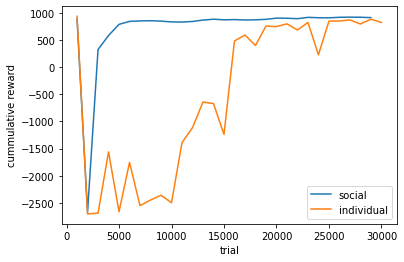

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i*1000+1000 for i in range(len(l))],l, label = "social")
plt.plot([i*1000+1000 for i in range(len(l_ind))],l_ind, label = "individual")
plt.legend()
plt.xlabel("trial")
plt.ylabel("cummulative reward")
plt.show()

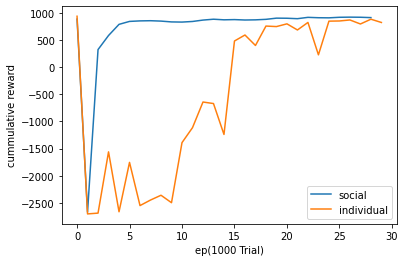

In [ ]:
import matplotlib.pyplot as plt
plt.plot(l, label = "social")
plt.plot(l_ind, label = "individual")
plt.legend()
plt.xlabel("ep(1000 Trial)")
plt.ylabel("cummulative reward")
plt.show()

In [ ]:
env = TorchBraxENV("ant",32)

In [ ]:
directory

'./exp__file__Ant-v2./'

In [ ]:
sl = socialDDPG(env,0)
l, ml = sl.train()

model has been loaded...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Total T:1000 Episode: 	0 Total Reward: 	650.62
Total T:2000 Episode: 	1 Total Reward: 	-196.98
Total T:3000 Episode: 	2 Total Reward: 	685.44
Total T:4000 Episode: 	3 Total Reward: 	799.24
Total T:5000 Episode: 	4 Total Reward: 	739.44
Total T:6000 Episode: 	5 Total Reward: 	782.09
Total T:7000 Episode: 	6 Total Reward: 	839.06
Total T:8000 Episode: 	7 Total Reward: 	879.19
Total T:9000 Episode: 	8 Total Reward: 	898.46


In [ ]:
l_ind = [937.52,-2704.41,-2689.66,-1561.22,-2664.71,-1755.17,-2550.89,-2448.73,-2360.56,-2497.7,-1391.19,-1115.64,-642.78,-671.05,-1240.16,481.49,591.91,399.04,756.63,747.09,797.43]

In [ ]:
l = [650.62, -196.98, 685.44, 799.24, 739.44, 782.09, 839.06, 879.19, 898.46]

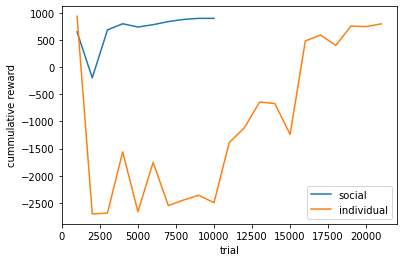

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i*1000+1000 for i in range(len(l))],l, label = "social")
plt.plot([i*1000+1000 for i in range(len(l_ind))],l_ind, label = "individual")
plt.legend()
plt.xlabel("trial")
plt.ylabel("cummulative reward")
plt.show()